In [1]:
import pandas as pd
 
def ee_array_to_df(arr, band):
    """
    We create a function with an array as input
    We return a pandas df
    """
    df = pd.DataFrame(arr)
     
    # we rearrange the header
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns = headers)
 
    # we remove raws without data inside:
    df = df[['longitude', 'latitude', 'time', band]].dropna()
     
    # We converr the data to numeric values
    df[band] = pd.to_numeric(df[band], errors='coerce')
     
    # We also convert the Time filed into a datetime
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')
     
    # We keep the columns we want
    # df = df[['time','datetime', band]]
     
    return df

In [3]:
# Import the Earth Engine Python Package
import ee # !pip install earthengine-api

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *

import geopandas as gpd

ee.Initialize()

In [4]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
from shapely.ops import unary_union
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../data/nir_green_blue/vectors/*.geojson'
shape_files = glob.glob(shape_file_path)
path = shape_files[6]

shape_files[0:3], cwd, path

(['../../data/nir_green_blue/vectors/Medan_017_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.geojson',
  '../../data/nir_green_blue/vectors/Denpasar_046_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.geojson',
  '../../data/nir_green_blue/vectors/Manila_028_pansharpen_True_2019-04-28_02:36_10300100915A0000_05-18-2020_08:55:26.geojson'],
 '/home/ubuntu/rimbun.io/03_Add_metadata/02_green_area_change',
 '../../data/nir_green_blue/vectors/Jakarta_202_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.geojson')

In [5]:
shapefile = gpd.read_file(path)

features = []
for i in range(shapefile.shape[0]):
    geom = shapefile.iloc[i:i+1,:] 
    jsonDict = eval(geom.to_json()) 
    geojsonDict = jsonDict['features'][0] 
    features.append(ee.Feature(geojsonDict)) 


In [6]:
multipoly = unary_union(shapefile.geometry)
multipoly_json = gpd.GeoSeries(multipoly).__geo_interface__


In [7]:
fc = ee.FeatureCollection(features)

In [8]:
shp_AOIs = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 
id_list = [pol['id'] for pol in fiona.open(path)]

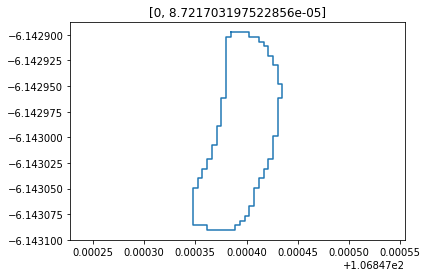

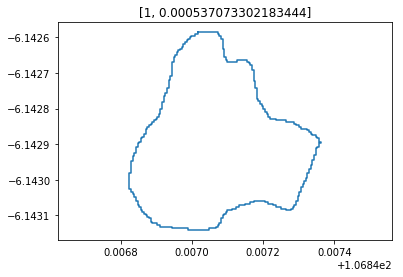

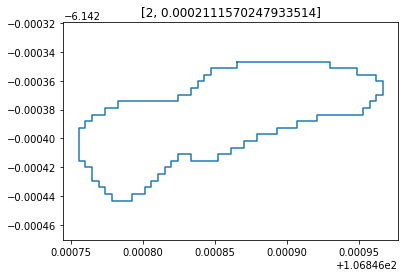

In [9]:
i = 0

sizes = []

for shape in shp_AOIs: 
    
    x = np.array(shape.exterior.coords.xy).T[:,0]
    y = np.array(shape.exterior.coords.xy).T[:,1]
    
    delta = x.max() - x.min()
    sizes.append([delta])

    plt.title([i, delta])
    plt.plot(x,y)
    plt.axis('equal')
    plt.show()
    
    i = i + 1

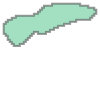

In [10]:
biggest_poly_index = np.array(sizes).argmax()

shp_AOIs[2]

In [11]:
osm_polygon = np.array(shp_AOIs[0].buffer(0.001).exterior.coords.xy).T


In [12]:
water_polygons_buffer = []

[water_polygons_buffer.append([np.array(poly.buffer(0.01).exterior.coords.xy).T.tolist() for poly in shp_AOIs])]

[None]

In [13]:
polygon_list = osm_polygon.tolist()

In [14]:
input_data = [[106.81591544702997, -6.33681462466857],
          [106.81591544702997, -6.350036929099756],
          [106.82780299738397, -6.350036929099756],
          [106.82780299738397, -6.33681462466857]]

In [15]:
input_data = polygon_list

In [16]:
type(input_data)

list

In [17]:
# set variables
SCALE = 10;
polarization = 'VV'; # vertical/vertical or vertical/horizontal

In [18]:
feature_geometry = {
    'type': 'MultiPolygon',
    'coordinates': [[[
        [-120, 35],
        [-120.001, 35],
        [-120.001, 35.001],
        [-120, 35.001],
        [-120, 35]
    ]]]
}

In [19]:
feature_geometry = {
    'type': 'MultiPolygon',
    'coordinates': [[polygon_list]]
}

In [20]:
# build geometry to measure
rect = ee.Geometry.Polygon([polygon_list])

In [21]:
# # build geometry to measure
# rect = ee.Geometry.MultiPolygon(water_polygons_buffer)

In [22]:
# convert geometry to JSON format
rect_JSON = rect.getInfo()['coordinates']

In [58]:
# initiate google earth engine to aquire the image
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterDate('2019-01-01', '2019-12-12')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.select(polarization)\
.filterBounds(rect)\


In [59]:
# visualize resulting image
img_url = S1.first().getThumbUrl({
    'region':rect,
    'min':-25,
    'max':0,
    'palette':['0784b5', '39ace7', '9bd4e4', 'cadeef', 'ffffff']
})



# Image(url = img_url)

maxPixels = 99999999

In [60]:
isinstance(rect, ee.ComputedObject)

True

In [61]:
img_data = S1.getRegion(feature_geometry, scale = 10);

In [83]:
arr = S1.getRegion(rect, 10).getInfo()

In [84]:
img_data

In [85]:
df = ee_array_to_df(arr, 'VV')

In [86]:
import geopandas as gpd

In [87]:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude))

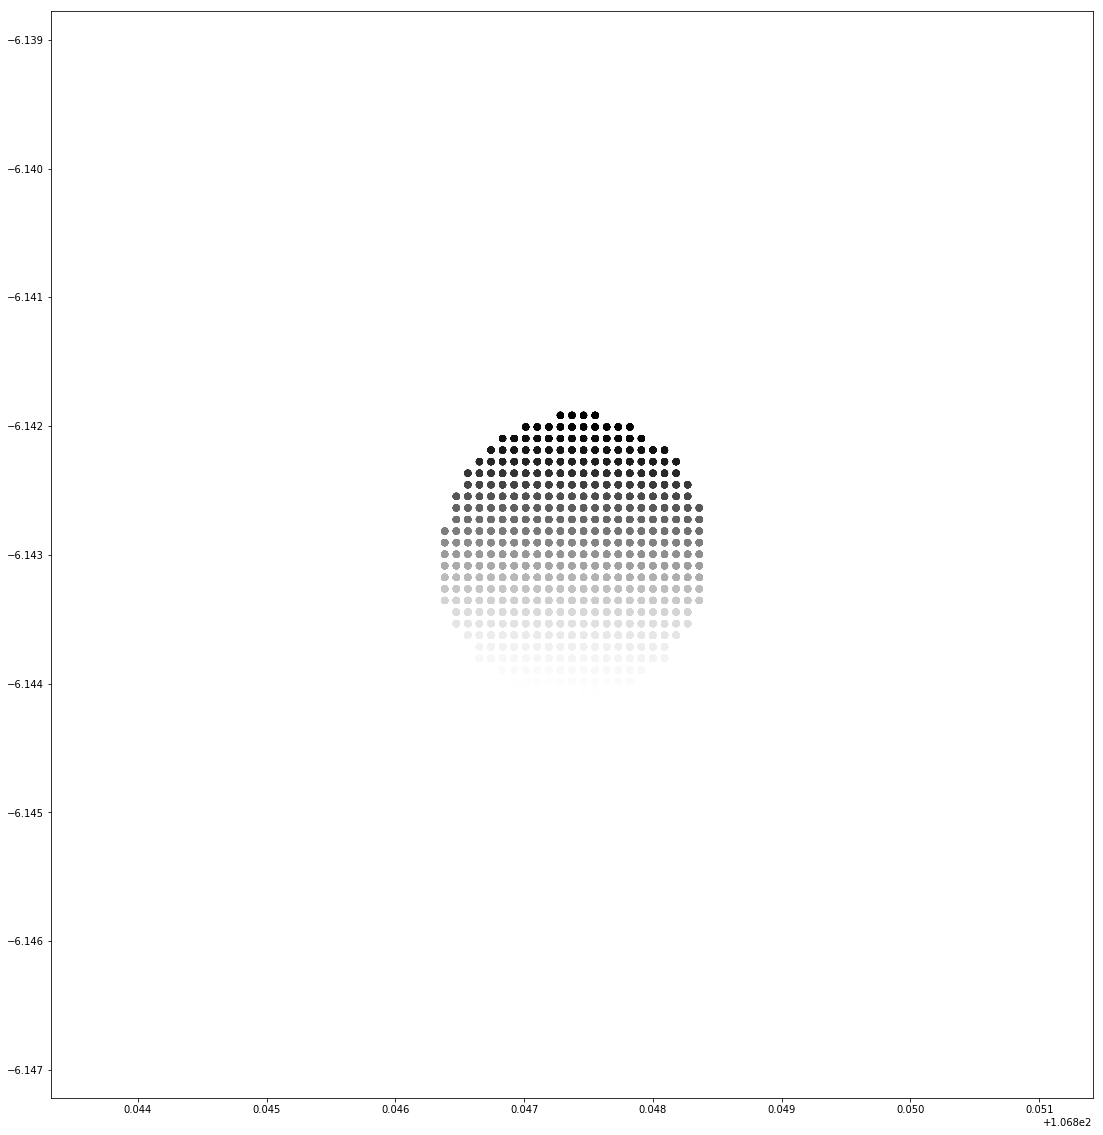

In [89]:
gdf.plot(figsize = (20,20), cmap='Greys')

In [75]:
gdf.VV

0        -8.042330
1        -7.885690
2        -9.793985
3        -7.894676
4        -6.019368
5        -7.643046
6        -5.208099
7        -7.993025
8        -5.182497
9         1.942642
10        0.255365
11       -5.437843
12        4.802705
13       -2.771500
14       -4.920577
15       -5.651336
16       -3.628029
17       -2.766140
18       -3.788879
19       -3.532322
20       -3.864007
21       -3.471647
22       -2.142446
23       -3.803818
24       -9.840691
25      -11.315323
26      -11.639470
27       -9.416145
28      -10.380621
29      -10.296854
           ...    
10770    -7.943165
10771   -12.276099
10772   -10.149052
10773   -11.234345
10774   -10.501732
10775   -11.068542
10776   -12.759096
10777   -12.010756
10778   -10.829899
10779   -10.018859
10780    -9.879048
10781   -10.844992
10782    -9.851216
10783   -11.471237
10784   -10.210383
10785    -9.833737
10786   -11.043377
10787    -7.102392
10788    -9.932330
10789    -9.620995
10790   -10.378198
10791   -10.

(106.8431677061401,
 106.85157550981977,
 -6.1473796076359974,
 -6.138609038681462)

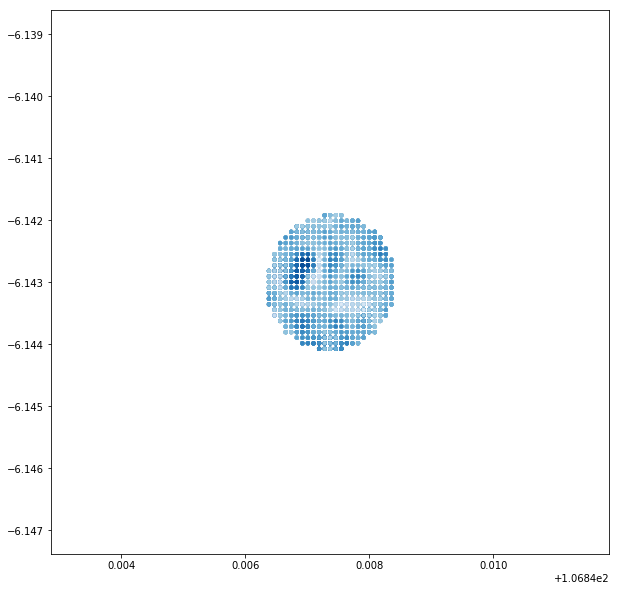

In [68]:
fig = plt.figure(figsize = (10,10))

plt.scatter(df.longitude, df.latitude, c=df.VV, cmap='Blues', s = 10)
plt.axis('equal')

In [69]:
img_url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28002040115c9c6fa45bf550d4d153a9-35c8f5e209e8a844361131a576525bf2:getPixels'

(25, 24, 4)


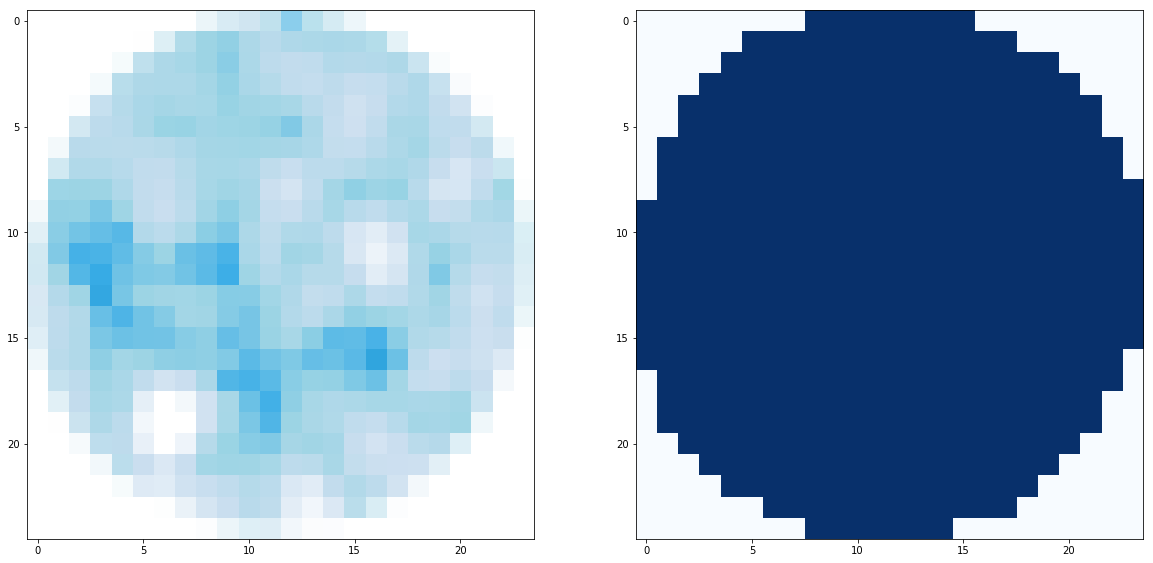

In [70]:
import imageio

# download image as np array
im = imageio.imread(img_url)

# apply value mask
array_mask = np.array(im == 0).astype(int)

print(array_mask.shape)

# plot results
plt.figure(figsize = (20,20))
plt.subplot(121)
plt.imshow(im, cmap = 'jet')
plt.subplot(122)
plt.imshow(-array_mask[:,:,0], cmap = 'Blues')

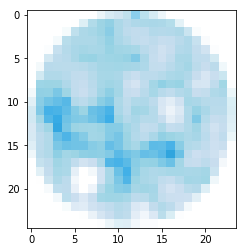

In [71]:
plt.imshow(im)